In [1]:
import tensorflow as tf
from keras import Model, Input
from keras.layers import Layer

import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs

from pyproj import Transformer
import matplotlib.axes as maxes

from glob import glob
import sys
import os

from satpy import Scene
import cartopy.feature as cfeature
import copy

import geopandas as gpd

from mpl_toolkits.axes_grid1 import make_axes_locatable

2025-09-22 15:47:05.077485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758556025.099167     624 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758556025.105886     624 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758556025.124306     624 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758556025.124320     624 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758556025.124322     624 computation_placer.cc:177] computation placer alr

In [2]:
# special class made for allowing the models (developed in keras 2) to be loaded in keras 3
class TFSMLayer(Layer):
    def __init__(self, filepath, call_endpoint="serving_default", **kwargs):
        super().__init__(**kwargs)
        self.filepath = filepath
        self.call_endpoint = call_endpoint
        self._infer = None  # will be loaded in build()

    def build(self, input_shape):
        # Load SavedModel once; save the TF function to self._infer
        self._loaded_model = tf.saved_model.load(self.filepath)
        self._infer = self._loaded_model.signatures[self.call_endpoint]
        super().build(input_shape)

    def call(self, inputs):
        # Ensure inputs are a tensor, pass through TF function, return the tensor output
        outputs = self._infer(inputs)
        
        # Pick the actual tensor output key here (adjust if needed)
        #return outputs['max_pooling2d_4']
        return list(outputs.values())[0] 

    def compute_output_shape(self, input_shape):
        # Return the expected output shape, for example (None, 26, 26, 1)
        # You may need to adapt this based on your actual model output
        batch_size = input_shape[0]
        return (batch_size, 26, 26, 1)

    def get_config(self):
        config = super().get_config()
        config.update({
            'filepath': self.filepath,
            'call_endpoint': self.call_endpoint,
        })
        return config

In [5]:
def load_tiles(time, hrit_file_path, tile_size=416, overlap=16):

    # Use fast single glob + in-memory filtering
    base_path =  hrit_file_path+time[:-4]
    all_files = glob(base_path+'/*'+time+'*')

    ir_108_filenames = [f for f in all_files if 'IR_108' in f]
    epi_filenames    = [f for f in all_files if 'EPI' in f]
    pro_filenames    = [f for f in all_files if 'PRO' in f]
    filenames = ir_108_filenames + epi_filenames + pro_filenames

    # Initialize and load only needed channel
    scene = Scene(reader='seviri_l1b_hrit', filenames=filenames)
    scene.load(['IR_108'])
    IR_108 = scene["IR_108"]
    
    # Define projection and transformer
    proj = ccrs.Geostationary(central_longitude=0.0, satellite_height=35785831)    
    transformer_from_latlon = Transformer.from_crs("EPSG:4326", proj.to_proj4(), always_xy=True)
    
    # Geographic bounds of South Africa
    lon_min, lon_max = -1, 38.0
    lat_min, lat_max = -38.0, -11.5
    
    # Project all corners to geostationary coordinates
    xs, ys = zip(*[transformer_from_latlon.transform(lon, lat) for lon, lat in [
        (lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_min), (lon_max, lat_max)]])
    
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    
    # Find nearest indices in the IR_108 grid
    x_vals = IR_108.x.values
    y_vals = IR_108.y.values
    
    ix_min = np.abs(x_vals - x_min).argmin()
    ix_max = np.abs(x_vals - x_max).argmin()
    iy_min = np.abs(y_vals - y_min).argmin()
    iy_max = np.abs(y_vals - y_max).argmin()
    
    # Ensure proper ordering
    ix_start, ix_end = min(ix_min, ix_max), max(ix_min, ix_max)
    iy_start, iy_end = min(iy_min, iy_max), max(iy_min, iy_max)

    # Extract South Africa region
    data = IR_108.values[iy_start:iy_end+1, ix_start:ix_end+1]
    #data = np.fliplr(data)
    x_region = x_vals[ix_start:ix_end+1]
    y_region = y_vals[iy_start:iy_end+1]
    ny, nx = data.shape

    # Compute step size with overlap
    step = tile_size - overlap
    tiles = []
    for i in range(0, ny - tile_size + 1, step):
        for j in range(0, nx - tile_size + 1, step):
            tile = data[i:i+tile_size, j:j+tile_size]
            
            # Compute bounding coordinates
            x_tile = x_region[j:j+tile_size]
            y_tile = y_region[i:i+tile_size]
    
            tiles.append((np.fliplr(tile), (y_tile.min(), y_tile.max(), x_tile.min(), x_tile.max())))
    return tiles

In [7]:
def generate_SII_NowNet_nowcasts(tiles, tiles_1, nowcast_type, lead_time):
    
    # Deep copy tiles to get tuple structure and keep the coordinates (input tile array will be updated to nowcast array)
    nowcast_tiles = copy.deepcopy(tiles)
    
    # Build models once
    inputs = Input(shape=(416, 416, 2))
    outputs = TFSMLayer(filepath=model_file_path + str(lead_time) + '_' + nowcast_type, call_endpoint='serving_default', trainable=False)(inputs)
    model = Model(inputs, outputs)
    
    for i in range(len(tiles)):
    
        # stack the input data and normalise
        input_data = np.dstack([tiles_1[i][0], tiles[i][0]])
        input_data = normalize(input_data, max_val, min_val)[np.newaxis]  # (1,416,416,2)
    
        # apply SII-NowNet models to the data and the replace tuples with updated nowcast data
        nowcast = model.predict(input_data, verbose=0)[0, :, :, 0]
        nowcast_tiles[i] = (nowcast, nowcast_tiles[i][1])

    # re-order the tiles so that they start in top left. Order goes from top lef to top right, then bottom left to bottom right 
    nowcasts = np.stack([nowcast_tiles[n][0] for n in range(len(nowcast_tiles)-1,-1,-1)])

    # start the process of averaging edges and placing them on the larger grid
    tile_size = 26
    overlap = tile_size - 1  # amount of overlap in pixels
    
    # vertical overlaps (right edge of left tile, left edge of right tile)
    vertical_pairs = [(0, 1), (1, 2), (3, 4), (4, 5)]
    for a, b in vertical_pairs:
        mean_vals = (nowcasts[a][:, -1:] + nowcasts[b][:, :1]) / 2
        nowcasts[a][:, -1:] = nowcasts[b][:, :1] = mean_vals
    
    # horizontal overlaps (bottom edge of top tile, top edge of bottom tile)
    horizontal_pairs = [(0, 3), (1, 4), (2, 5)]
    for a, b in horizontal_pairs:
        mean_vals = (nowcasts[a][:1, :] + nowcasts[b][-1:, :]) / 2
        nowcasts[a][:1, :] = nowcasts[b][-1:, :] = mean_vals
    
    # setup empty array for processed tiles
    nowcast_plot = np.zeros((tile_size*2 - 1, tile_size*3 - 2))
    
    # place tiles in grid automatically
    for i in range(2):          # rows
        for j in range(3):      # cols
            idx = (1 - i) * 3 + j   # flips row order (starts at top left)
            r, c = i*overlap, j*overlap
            nowcast_plot[r:r+tile_size, c:c+tile_size] = nowcasts[idx]
    
    return nowcast_plot 

In [8]:
def save_nowcast_plot(nowcast_data, nowcast_type, lead_time, nowcast_fig_file_path):

    # set projection transformer up
    proj = ccrs.Geostationary(central_longitude=0.0, satellite_height=35785831)    
    transformer_from_latlon = Transformer.from_crs("EPSG:4326", proj.to_proj4(), always_xy=True)
    
    # Wider geographic bounds of South Africa domain
    lon_min, lon_max = -1, 38.0
    lat_min, lat_max = -38.0, -11.5
    
    # Project all corners to geostationary coordinates 
    xs, ys = zip(*[transformer_from_latlon.transform(lon, lat) for lon, lat in [(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_min), (lon_max, lat_max)]])
    full_domain_x_min, full_domain_x_max = min(xs), max(xs)
    full_domain_y_min, full_domain_y_max = min(ys), max(ys)
    
    # Focussed geographic bounds of South Africa domain
    f_lat_min, f_lat_max = -38.0, -15
    f_lon_min, f_lon_max = 10, 38
    
    # Transform to projection coordinates
    f_x_min, f_y_min = transformer_from_latlon.transform(f_lon_min, f_lat_min)
    f_x_max, f_y_max = transformer_from_latlon.transform(f_lon_max, f_lat_max)
    
    # start building figure
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection=proj)
    
    # add borders and coastlines
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='darkseagreen',alpha=0.9)
    ax.coastlines(resolution='10m', color='darkseagreen',alpha=0.9)
    
    # set focussed limit
    ax.set(xlim=[f_x_min, f_x_max], ylim=[f_y_min, f_y_max], transform=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    
    # add provinces
    province_gdf = gpd.read_file('/home/users/eejasm/SAWS/Provinces/south_africa_Province_level_1.shp')
    # simplify shapes in degrees (tune 0.01 → ~1km at equator)
    province_gdf["geometry"] = province_gdf.geometry.simplify(0.01, preserve_topology=True)
    province_boundaries = cfeature.ShapelyFeature(province_gdf.boundary, ccrs.PlateCarree(), facecolor="none", edgecolor="black")
    ax.add_feature(province_boundaries, alpha=0.6, linewidth=0.6, zorder=10)
    
    # plot nowcast data and set focussed limit
    if nowcast_type == 'Intensification':
        
        tol_precip_colors = ["gainsboro", "lightblue", "#6195CF","#F7CB45","#EE8026","#DC050C","#A5170E","#72190E","#882E72","#000000"]
        precip_colormap = mpl.colors.ListedColormap(tol_precip_colors[:])
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        divider = make_axes_locatable(ax)
        plt.colorbar(mpl.cm.ScalarMappable(cmap=precip_colormap,norm=norm), label=nowcast_type+' probability',extend='neither',ticks=np.arange(0,1.1,0.1), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0.1, axes_class=maxes.Axes))

        ax.contourf(nowcast_data, transform=proj, vmin = 0, vmax= 1, extent=[full_domain_x_min, full_domain_x_max, full_domain_y_min, full_domain_y_max], cmap=precip_colormap)
        
    # plot nowcast data and set focussed limit
    if nowcast_type == 'Initiation':

        tol_precip_colors = ["gainsboro","gainsboro","lightblue", "#6195CF","#F7CB45","#EE8026","#DC050C","#A5170E","#72190E","#882E72","#000000"]
        precip_colormap = mpl.colors.ListedColormap(tol_precip_colors[:])
        bounds = [0,0.01,0.02,0.03,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
        norm = mpl.colors.BoundaryNorm(bounds,12, extend='both')
        divider = make_axes_locatable(ax)
        plt.colorbar(mpl.cm.ScalarMappable(cmap=precip_colormap,norm=norm), label=nowcast_type+' probability',extend='neither',ticks=bounds, cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0.1, axes_class=maxes.Axes))
        
        ax.contourf(nowcast_data, origin='lower', transform=proj, extent=[full_domain_x_min, full_domain_x_max, full_domain_y_min, full_domain_y_max], cmap=precip_colormap)


    date_str = initialisation_time[:8]  # YYYYMMDD
    output_dir = os.path.join(nowcast_fig_file_path, date_str)
    os.makedirs(output_dir, exist_ok=True)
    
    plt.savefig(output_dir+'/'+initialisation_time+'_'+nowcast_type+'_'+str(lead_time)+'.png', bbox_inches='tight')
    plt.show()

In [9]:
# normalize input data before insert to SII-NowNet - predefined max/min values
max_val = 327.67
min_val = 177.81
def normalize(array, max_val, min_val):
    array = (array - min_val) / (max_val - min_val + 1e-13)
    return array

In [12]:
# location of you HRIT BT data (IR 10.8um)
hrit_file_path = '/gws/ssde/j25b/swift/WISER-EWSA/HRIT/data/'
# location of the SII-NowNet models
model_file_path = '/home/users/eejasm/SAWS/no_optimizer_models/'
# location to save the nowcast images
nowcast_np_file_path = '/home/users/eejasm/SAWS/nowcast_arrays/'
# location to save the nowcast numpy arrays
nowcast_fig_file_path = '/home/users/eejasm/SAWS/figures/'

In [13]:
# Time argument needs to be in the format to fit the hrit_file_path so that load_data runs correctly (e.g. for me the HRIT data has the time format YYYYMMDDHHMM)
initialisation_time = '202503051100'

dt_initialisation_time_minus_1 = datetime.strptime(initialisation_time, '%Y%m%d%H%M') - timedelta(hours=1)
initialisation_time_minus_1 = datetime.strftime(dt_initialisation_time_minus_1, '%Y%m%d%H%M')

In [14]:
tiles = load_tiles(initialisation_time, hrit_file_path, tile_size=416, overlap=16)
tiles_1 = load_tiles(initialisation_time_minus_1, hrit_file_path, tile_size=416, overlap=16)

/opt/jaspy/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/jaspy/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


I0000 00:00:1758556073.286462     624 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8225 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.10gb, pci bus id: 0000:01:00.0, compute capability: 8.0
I0000 00:00:1758556075.446156    1882 service.cc:152] XLA service 0x7faa8801d6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758556075.446194    1882 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.10gb, Compute Capability 8.0
2025-09-22 15:47:55.466774: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758556075.625432    1882 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758556080.155492    1882 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


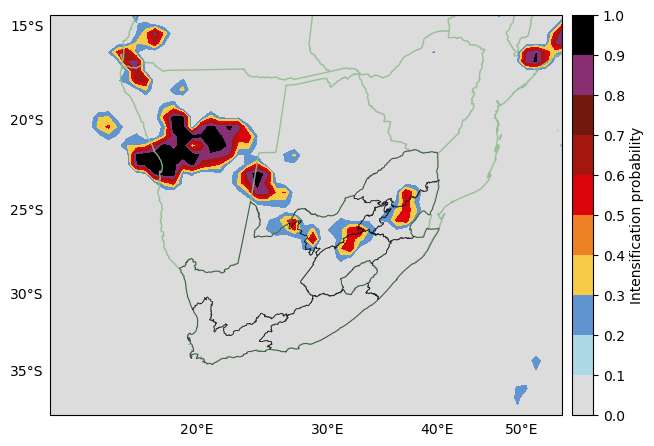

/opt/jaspy/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


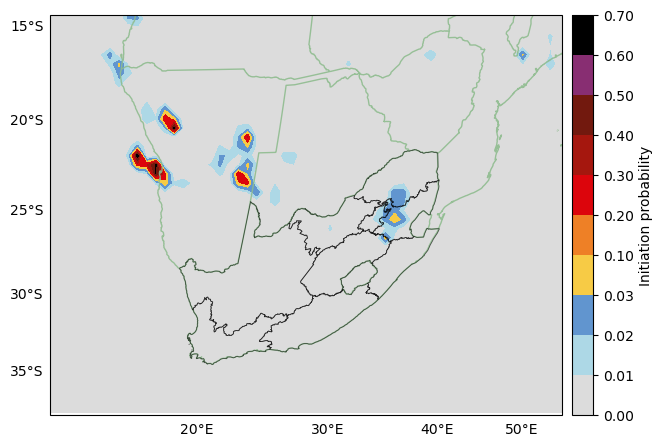

1


/opt/jaspy/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


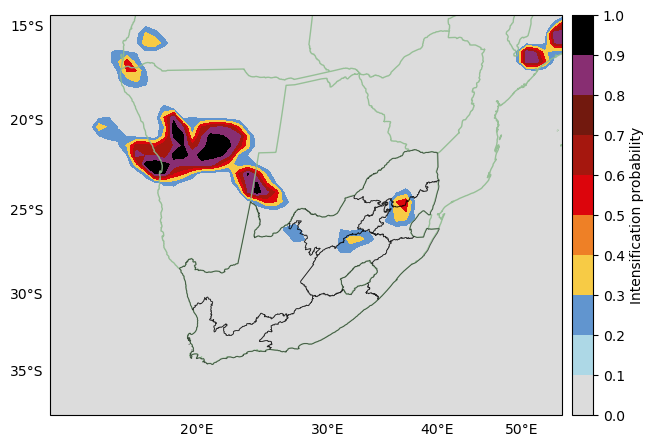

/opt/jaspy/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


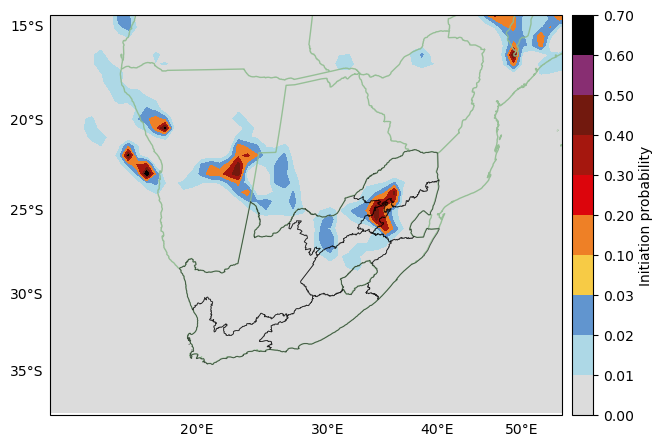

2


/opt/jaspy/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


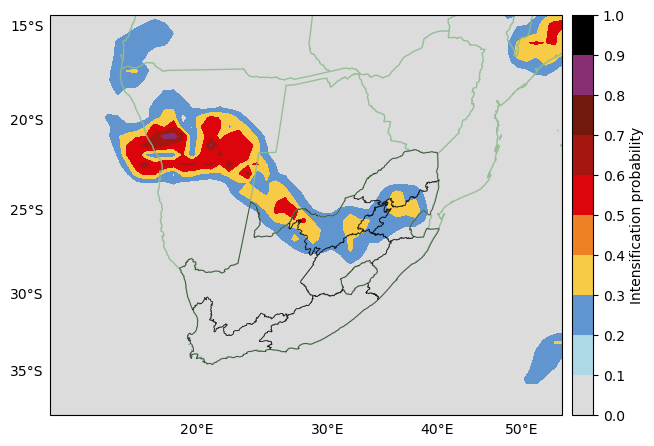

3


In [15]:
for lead_time in range(1,4):
     
    # make directory for saving the raw .np files
    date_str = initialisation_time[:8]  # YYYYMMDD
    output_dir = os.path.join(nowcast_np_file_path, date_str)
    os.makedirs(output_dir, exist_ok=True)
    
    # initiation only skilful for up to +2 hours 
    if lead_time == 3:
        intensification = generate_SII_NowNet_nowcasts(tiles, tiles_1, 'intensification', lead_time)
        save_nowcast_plot(intensification, 'Intensification', lead_time, nowcast_fig_file_path)
        
        np.save(nowcast_np_file_path+initialisation_time+'_intensification_'+str(lead_time)+'.npy', intensification)
    else:
        intensification = generate_SII_NowNet_nowcasts(tiles, tiles_1, 'intensification', lead_time)
        initiation = generate_SII_NowNet_nowcasts(tiles, tiles_1, 'initiation', lead_time)
        
        save_nowcast_plot(intensification, 'Intensification', lead_time, nowcast_fig_file_path)
        save_nowcast_plot(initiation, 'Initiation', lead_time, nowcast_fig_file_path)
        
        np.save(nowcast_np_file_path+initialisation_time+'_intensification_'+str(lead_time)+'.npy', intensification)
        np.save(nowcast_np_file_path+initialisation_time+'_initiation_'+str(lead_time)+'.npy', initiation)

    print(lead_time)  